<a href="https://colab.research.google.com/github/soroushsheikh/SoccerPredictionXGBoost/blob/main/SoccerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/SoccerPrediction

/content/drive/MyDrive/Colab_Notebooks/SoccerPrediction


In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [4]:
#loading the data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

<ipython-input-4-2d59f36b93f3>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input/train.csv')


In [5]:
train.columns

Index(['id', 'target', 'home_team_name', 'away_team_name', 'match_date',
       'league_name', 'league_id', 'is_cup', 'home_team_coach_id',
       'away_team_coach_id',
       ...
       'away_team_history_league_id_1', 'away_team_history_league_id_2',
       'away_team_history_league_id_3', 'away_team_history_league_id_4',
       'away_team_history_league_id_5', 'away_team_history_league_id_6',
       'away_team_history_league_id_7', 'away_team_history_league_id_8',
       'away_team_history_league_id_9', 'away_team_history_league_id_10'],
      dtype='object', length=190)

In [6]:
train.head

<bound method NDFrame.head of               id target      home_team_name         away_team_name  \
0       11906497   away   Newell's Old Boys            River Plate   
1       11984383   home         Real Estelí  Deportivo Las Sabanas   
2       11983301   draw               UPNFM               Marathón   
3       11983471   away                León                Morelia   
4       11883005   home      Cobán Imperial                 Iztapa   
...          ...    ...                 ...                    ...   
110933  18030016   draw  Zamora Fútbol Club    Hermanos Colmenares   
110934  18030096   away          Royal Pari      Oriente Petrolero   
110935  17715497   draw        São Bernardo             Água Santa   
110936  17944153   away             Everton              La Serena   
110937  17786297   home               Colón     Arsenal de Sarandi   

                 match_date          league_name  league_id is_cup  \
0       2019-12-01 00:45:00            Superliga        636

In [7]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [8]:
def has_coach_change(df):
    '''introducing a new feature indicating whether home and away teams have changed coach'''
    
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [9]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [10]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]
def convert_to_long_form(df, feature_columns, history_columns):
    '''coverting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [11]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')
        
        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')
        
    return df

In [12]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [13]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    
    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']
    
    home_team_history_goal_info_available=df.groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_history_goal_info_available.to_frame(name='home_team_history_goal_info_available'), on='id')
    away_team_history_goal_info_available=df.groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_history_goal_info_available.to_frame(name='away_team_history_goal_info_available'), on='id')
    home_team_history_rating_info_available=df.groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_history_rating_info_available.to_frame(name='home_team_history_rating_info_available'), on='id')
    away_team_history_rating_info_available=df.groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_history_rating_info_available.to_frame(name='away_team_history_rating_info_available'), on='id')
    
        
    for i in [5,10]:
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(name=f'home_team_history_average_goal_conceded_{i}'), on='id')
        
        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'), on='id')
        
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        
        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')
        
        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')
    
    home_team_home_form_average_goal_scored=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal.mean()
    df=df.join(home_team_home_form_average_goal_scored.to_frame(name='home_team_home_form_average_goal_scored'), on='id')
    home_team_home_form_average_goal_conceded=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_opponent_goal.mean()
    df=df.join(home_team_home_form_average_goal_conceded.to_frame(name='home_team_home_form_average_goal_conceded'), on='id')
    home_team_home_form_average_goal_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.mean()
    df=df.join(home_team_home_form_average_goal_difference.to_frame(name='home_team_home_form_average_goal_difference'), on='id')
    home_team_home_form_goal_difference_std=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.std()
    df=df.join(home_team_home_form_goal_difference_std.to_frame(name='home_team_home_form_goal_difference_std'), on='id')
    home_team_home_form_win_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==3)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_win_rate.to_frame(name='home_team_home_form_win_rate'), on='id')
    home_team_home_form_draw_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==1)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_draw_rate.to_frame(name='home_team_home_form_draw_rate'), on='id')
    home_team_home_form_lose_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==0)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_lose_rate.to_frame(name='home_team_home_form_lose_rate'), on='id')
    home_team_home_form_average_point=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_point.mean()
    df=df.join(home_team_home_form_average_point.to_frame(name='home_team_home_form_average_point'), on='id')
    home_team_home_form_median_rating_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.median()
    df=df.join(home_team_home_form_median_rating_difference.to_frame(name='home_team_home_form_median_rating_difference'), on='id')
    home_team_home_form_goal_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_home_form_goal_info_available.to_frame(name='home_team_home_form_goal_info_available'), on='id')
    home_team_home_form_rating_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_home_form_rating_info_available.to_frame(name='home_team_home_form_rating_info_available'), on='id')
    
    away_team_away_form_average_goal_scored=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal.mean()
    df=df.join(away_team_away_form_average_goal_scored.to_frame(name='away_team_away_form_average_goal_scored'), on='id')
    away_team_away_form_average_goal_conceded=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_opponent_goal.mean()
    df=df.join(away_team_away_form_average_goal_conceded.to_frame(name='away_team_away_form_average_goal_conceded'), on='id')
    away_team_away_form_average_goal_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.mean()
    df=df.join(away_team_away_form_average_goal_difference.to_frame(name='away_team_away_form_average_goal_difference'), on='id')
    away_team_away_form_goal_difference_std=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.std()
    df=df.join(away_team_away_form_goal_difference_std.to_frame(name='away_team_away_form_goal_difference_std'), on='id')
    away_team_away_form_win_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==3)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_win_rate.to_frame(name='away_team_away_form_win_rate'), on='id')
    away_team_away_form_draw_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==1)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_draw_rate.to_frame(name='away_team_away_form_draw_rate'), on='id')
    away_team_away_form_lose_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==0)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_lose_rate.to_frame(name='away_team_away_form_lose_rate'), on='id')
    away_team_away_form_average_point=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_point.mean()
    df=df.join(away_team_away_form_average_point.to_frame(name='away_team_away_form_average_point'), on='id')
    away_team_away_form_median_rating_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.median()
    df=df.join(away_team_away_form_median_rating_difference.to_frame(name='away_team_away_form_median_rating_difference'), on='id')
    away_team_away_form_goal_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_away_form_goal_info_available.to_frame(name='away_team_away_form_goal_info_available'), on='id')
    away_team_away_form_rating_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_away_form_rating_info_available.to_frame(name='away_team_away_form_rating_info_available'), on='id')
    
    return df

In [14]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals based on this'''
    
    home_history_columns=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id']
    home_history=df[home_history_columns]
    home_history=home_history.drop_duplicates()
    
    away_history_columns=['away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    away_history=df[away_history_columns]
    away_history=away_history.drop_duplicates()
    
    league_total_goal = home_history.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = home_history.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.count() 
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal=df.league_average_goal.fillna(df.league_average_goal.mean())
    
    league_total_home_goal = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    df.league_average_home_goal=df.league_average_home_goal.fillna(df.league_average_home_goal.mean())
    
    league_total_away_goal = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    df.league_average_away_goal=df.league_average_away_goal.fillna(df.league_average_away_goal.mean())
    
    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength
    
    
    #getting teams' record of goal scored and conceded in each league
    home_team_league_average_goal_scored=df.groupby(['id','home_team_history_league_id']).home_team_history_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_scored.columns=['id','league_id','home_team_league_average_goal_scored']
    df=pd.merge(df, home_team_league_average_goal_scored, how='left')
    
    home_team_league_average_goal_conceded=df.groupby(['id','home_team_history_league_id']).home_team_history_opponent_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_conceded.columns=['id','league_id','home_team_league_average_goal_conceded']
    df=pd.merge(df, home_team_league_average_goal_conceded, how='left')
    
    away_team_league_average_goal_scored=df.groupby(['id','away_team_history_league_id']).away_team_history_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_scored.columns=['id','league_id','away_team_league_average_goal_scored']
    df=pd.merge(df, away_team_league_average_goal_scored, how='left')
    
    away_team_league_average_goal_conceded=df.groupby(['id','away_team_history_league_id']).away_team_history_opponent_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_conceded.columns=['id','league_id','away_team_league_average_goal_conceded']
    df=pd.merge(df, away_team_league_average_goal_conceded, how='left')
    
    #setting another set of attack, defense and expected goal data based on team's record
    df['home_team_league_attack_strength'] = df.home_team_league_average_goal_scored/df.league_average_goal
    df['home_team_league_defense_strength'] = df.home_team_league_average_goal_conceded/df.league_average_goal
    df['away_team_league_attack_strength'] = df.away_team_league_average_goal_scored/df.league_average_goal
    df['away_team_league_defense_strength'] = df.away_team_league_average_goal_conceded/df.league_average_goal
    df['home_team_league_expected_goal'] = df.league_average_home_goal*df.home_team_league_attack_strength*df.away_team_league_defense_strength
    df['away_team_league_expected_goal'] = df.league_average_away_goal*df.away_team_league_attack_strength*df.home_team_league_defense_strength
    
    #getting coach's record of goal scored and conceded in each league
    home_coach_goal=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_goal']].dropna()
    home_coach_goal=home_coach_goal.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_goal2=home_coach_goal.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_goal2['home_team_coach_league_average_goal_scored']=(home_coach_goal2['cumsum'])/(home_coach_goal2['cumcount']+1)
    home_coach_goal3=home_coach_goal2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_scored']]
    home_coach_goal3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_scored']
    home_coach_goal3=home_coach_goal3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_goal3, how='left')
    
    home_coach_conceded=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_opponent_goal']].dropna()
    home_coach_conceded=home_coach_conceded.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_conceded2=home_coach_conceded.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_conceded2['home_team_coach_league_average_goal_conceded']=(home_coach_conceded2['cumsum'])/(home_coach_conceded2['cumcount']+1)
    home_coach_conceded3=home_coach_conceded2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_conceded']]
    home_coach_conceded3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_conceded']
    home_coach_conceded3=home_coach_conceded3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_conceded3, how='left')
    
    away_coach_goal=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_goal']].dropna()
    away_coach_goal=away_coach_goal.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_goal2=away_coach_goal.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_goal2['away_team_coach_league_average_goal_scored']=(away_coach_goal2['cumsum'])/(away_coach_goal2['cumcount']+1)
    away_coach_goal3=away_coach_goal2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_scored']]
    away_coach_goal3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_scored']
    away_coach_goal3=away_coach_goal3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_goal3, how='left')
    
    away_coach_conceded=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_opponent_goal']].dropna()
    away_coach_conceded=away_coach_conceded.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_conceded2=away_coach_conceded.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_conceded2['away_team_coach_league_average_goal_conceded']=(away_coach_conceded2['cumsum'])/(away_coach_conceded2['cumcount']+1)
    away_coach_conceded3=away_coach_conceded2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_conceded']]
    away_coach_conceded3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_conceded']
    away_coach_conceded3=away_coach_conceded3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_conceded3, how='left')
    
    #setting another set of attack, defense and expected goal data based on coach's record
    df['home_team_coach_attack_strength'] = df.home_team_coach_league_average_goal_scored/df.league_average_goal
    df['home_team_coach_defense_strength'] = df.home_team_coach_league_average_goal_conceded/df.league_average_goal
    df['away_team_coach_attack_strength'] = df.away_team_coach_league_average_goal_scored/df.league_average_goal
    df['away_team_coach_defense_strength'] = df.away_team_coach_league_average_goal_conceded/df.league_average_goal
    df['home_team_coach_expected_goal'] = df.league_average_home_goal*df.home_team_coach_attack_strength*df.away_team_coach_defense_strength
    df['away_team_coach_expected_goal'] = df.league_average_away_goal*df.away_team_coach_attack_strength*df.home_team_coach_defense_strength
    
    return df

In [15]:
def reshape(df):
    '''reshape the dataframe back to wide form'''
    history_columns=['home_team_history_is_play_home',
              'home_team_history_is_cup',
              'home_team_history_goal',
              'home_team_history_opponent_goal',
              'home_team_history_rating',
              'home_team_history_opponent_rating',
              'home_team_history_coach',
              'home_team_history_league_id',
              'home_team_history_goal_difference',
              'home_team_history_point',
              'home_team_history_rating_difference',
              'away_team_history_is_play_home',
              'away_team_history_is_cup',
              'away_team_history_goal',
              'away_team_history_opponent_goal',
              'away_team_history_rating',
              'away_team_history_opponent_rating',
              'away_team_history_coach',
              'away_team_history_league_id',
              'away_team_history_goal_difference',
              'away_team_history_point',
              'away_team_history_rating_difference']
    drop_columns=['match','match_date','home_team_history_match_date','away_team_history_match_date']
    df_history=df[history_columns+['id','match']].set_index(['id','match']).unstack(level=1)
    df_history.columns = df_history.columns.map('{0[0]}_{0[1]}'.format) 
    df_history=df_history.reset_index()
    df_new=df.groupby('id').first().reset_index().drop(history_columns+drop_columns, axis=1)
    df_new=df_new.merge(df_history, how='left')
    
    return df_new
    

In [16]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df=reshape(df)

    return df

In [17]:
train_p=preprocession(train)


In [18]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11864226
home_has_coach_change 0
home_team_coach_id 456984.0
is_cup 0.0
league_id 453
away_team_coach_id 458731.0
away_has_coach_change 0
home_team_history_match_interval_1 80.9375
away_team_history_match_interval_1 85.0625
home_team_history_match_interval_2 80.9375
away_team_history_match_interval_2 85.0625
home_team_history_match_interval_5 80.9375
away_team_history_match_interval_5 85.0625
home_team_history_goal_info_available 10
away_team_history_goal_info_available 10
home_team_history_rating_info_available 10
away_team_history_rating_info_available 10
home_team_history_average_goal_scored_5 1.6
home_team_history_average_goal_conceded_5 2.0
away_team_history_average_goal_scored_5 1.0
away_team_history_average_goal_conceded_5 1.6
home_team_history_average_goal_difference_5 -0.3999999999999999
away_team_history_average_goal_difference_5 -0.6000000000000001
home_team_history_average_point_5 1.4
away_team_history_average_point_5 0.8
home_team_history_average_point_std_5 1.516575088

In [19]:
train_p

,id,home_has_coach_change,home_team_coach_id,is_cup,league_id,away_team_coach_id,away_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,11428294,1,468693.0,0.0,755,257433.0,0,6.083333,5.083333,6.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,11428295,1,37331516.0,0.0,755,16476269.0,0,4.000000,4.083333,4.000000,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,11428297,1,212710.0,0.0,755,474745.0,0,3.916667,6.000000,3.916667,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,11428298,0,186127.0,0.0,755,472575.0,0,4.083333,3.000000,4.083333,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,11428299,0,470514.0,0.0,755,216631.0,0,3.000000,4.000000,3.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18045358,1,NaN,0.0,827,NaN,0,4.083333,11.104167,4.083333,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,18046139,1,37568493.0,0.0,974,1552546.0,0,56.906250,61.000000,56.906250,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,18046140,0,22859379.0,0.0,974,17905337.0,0,57.135417,57.031250,57.135417,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,18046141,1,29328646.0,0.0,974,2206663.0,0,56.208333,57.218750,56.208333,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


In [20]:
X=train_p.drop('id', axis=1)
y=train.sort_values(by='id')['target']

In [21]:
X

,home_has_coach_change,home_team_coach_id,is_cup,league_id,away_team_coach_id,away_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,1,468693.0,0.0,755,257433.0,0,6.083333,5.083333,6.083333,5.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,1,37331516.0,0.0,755,16476269.0,0,4.000000,4.083333,4.000000,4.083333,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,1,212710.0,0.0,755,474745.0,0,3.916667,6.000000,3.916667,6.000000,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,0,186127.0,0.0,755,472575.0,0,4.083333,3.000000,4.083333,3.000000,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,0,470514.0,0.0,755,216631.0,0,3.000000,4.000000,3.000000,4.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,1,NaN,0.0,827,NaN,0,4.083333,11.104167,4.083333,11.104167,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,1,37568493.0,0.0,974,1552546.0,0,56.906250,61.000000,56.906250,61.000000,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,0,22859379.0,0.0,974,17905337.0,0,57.135417,57.031250,57.135417,57.031250,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,1,29328646.0,0.0,974,2206663.0,0,56.208333,57.218750,56.208333,57.218750,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [23]:
from sklearn import model_selection
X_train, X_valid_test, y_train, y_valid_test = model_selection.train_test_split(X, label_encoded_y, train_size=0.7, random_state=42)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid_test, y_valid_test, train_size=0.5, random_state=41)

In [24]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [25]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.025,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.25,
    'alpha': 2,
    'lambda': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [26]:
model = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20)


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.09564	eval-mlogloss:1.09581
[1]	train-mlogloss:1.09276	eval-mlogloss:1.09310
[2]	train-mlogloss:1.08999	eval-mlogloss:1.09054
[3]	train-mlogloss:1.08749	eval-mlogloss:1.08820
[4]	train-mlogloss:1.08492	eval-mlogloss:1.08583
[5]	train-mlogloss:1.08241	eval-mlogloss:1.08346
[6]	train-mlogloss:1.08001	eval-mlogloss:1.08116
[7]	train-mlogloss:1.07776	eval-mlogloss:1.07908
[8]	train-mlogloss:1.07558	eval-mlogloss:1.07708
[9]	train-mlogloss:1.07333	eval-mlogloss:1.07499
[10]	train-mlogloss:1.07114	eval-mlogloss:1.07300
[11]	train-mlogloss:1.06916	eval-mlogloss:1.07120
[12]	train-mlogloss:1.06714	eval-mlogloss:1.06930
[13]	train-mlogloss:1.06521	eval-mlogloss:1.06753
[14]	train-mlogloss:1.06326	eval-mlogloss:1.06572
[15]	train-mlogloss:1.06144	eval-mlogloss:1.06410
[16]	train-mlogloss:1.05974	eval-mlogloss:1.06257
[17]	train-mlogloss:1.05810	eval-mlogloss:1.06115
[18]	train-mlogloss:1.05639	eval-mlogloss:1.05959
[19]	train-mlogloss:1.05476	eval-mlogloss:1.05812
[20]	train

In [27]:
model.save_model('trained_model.model')

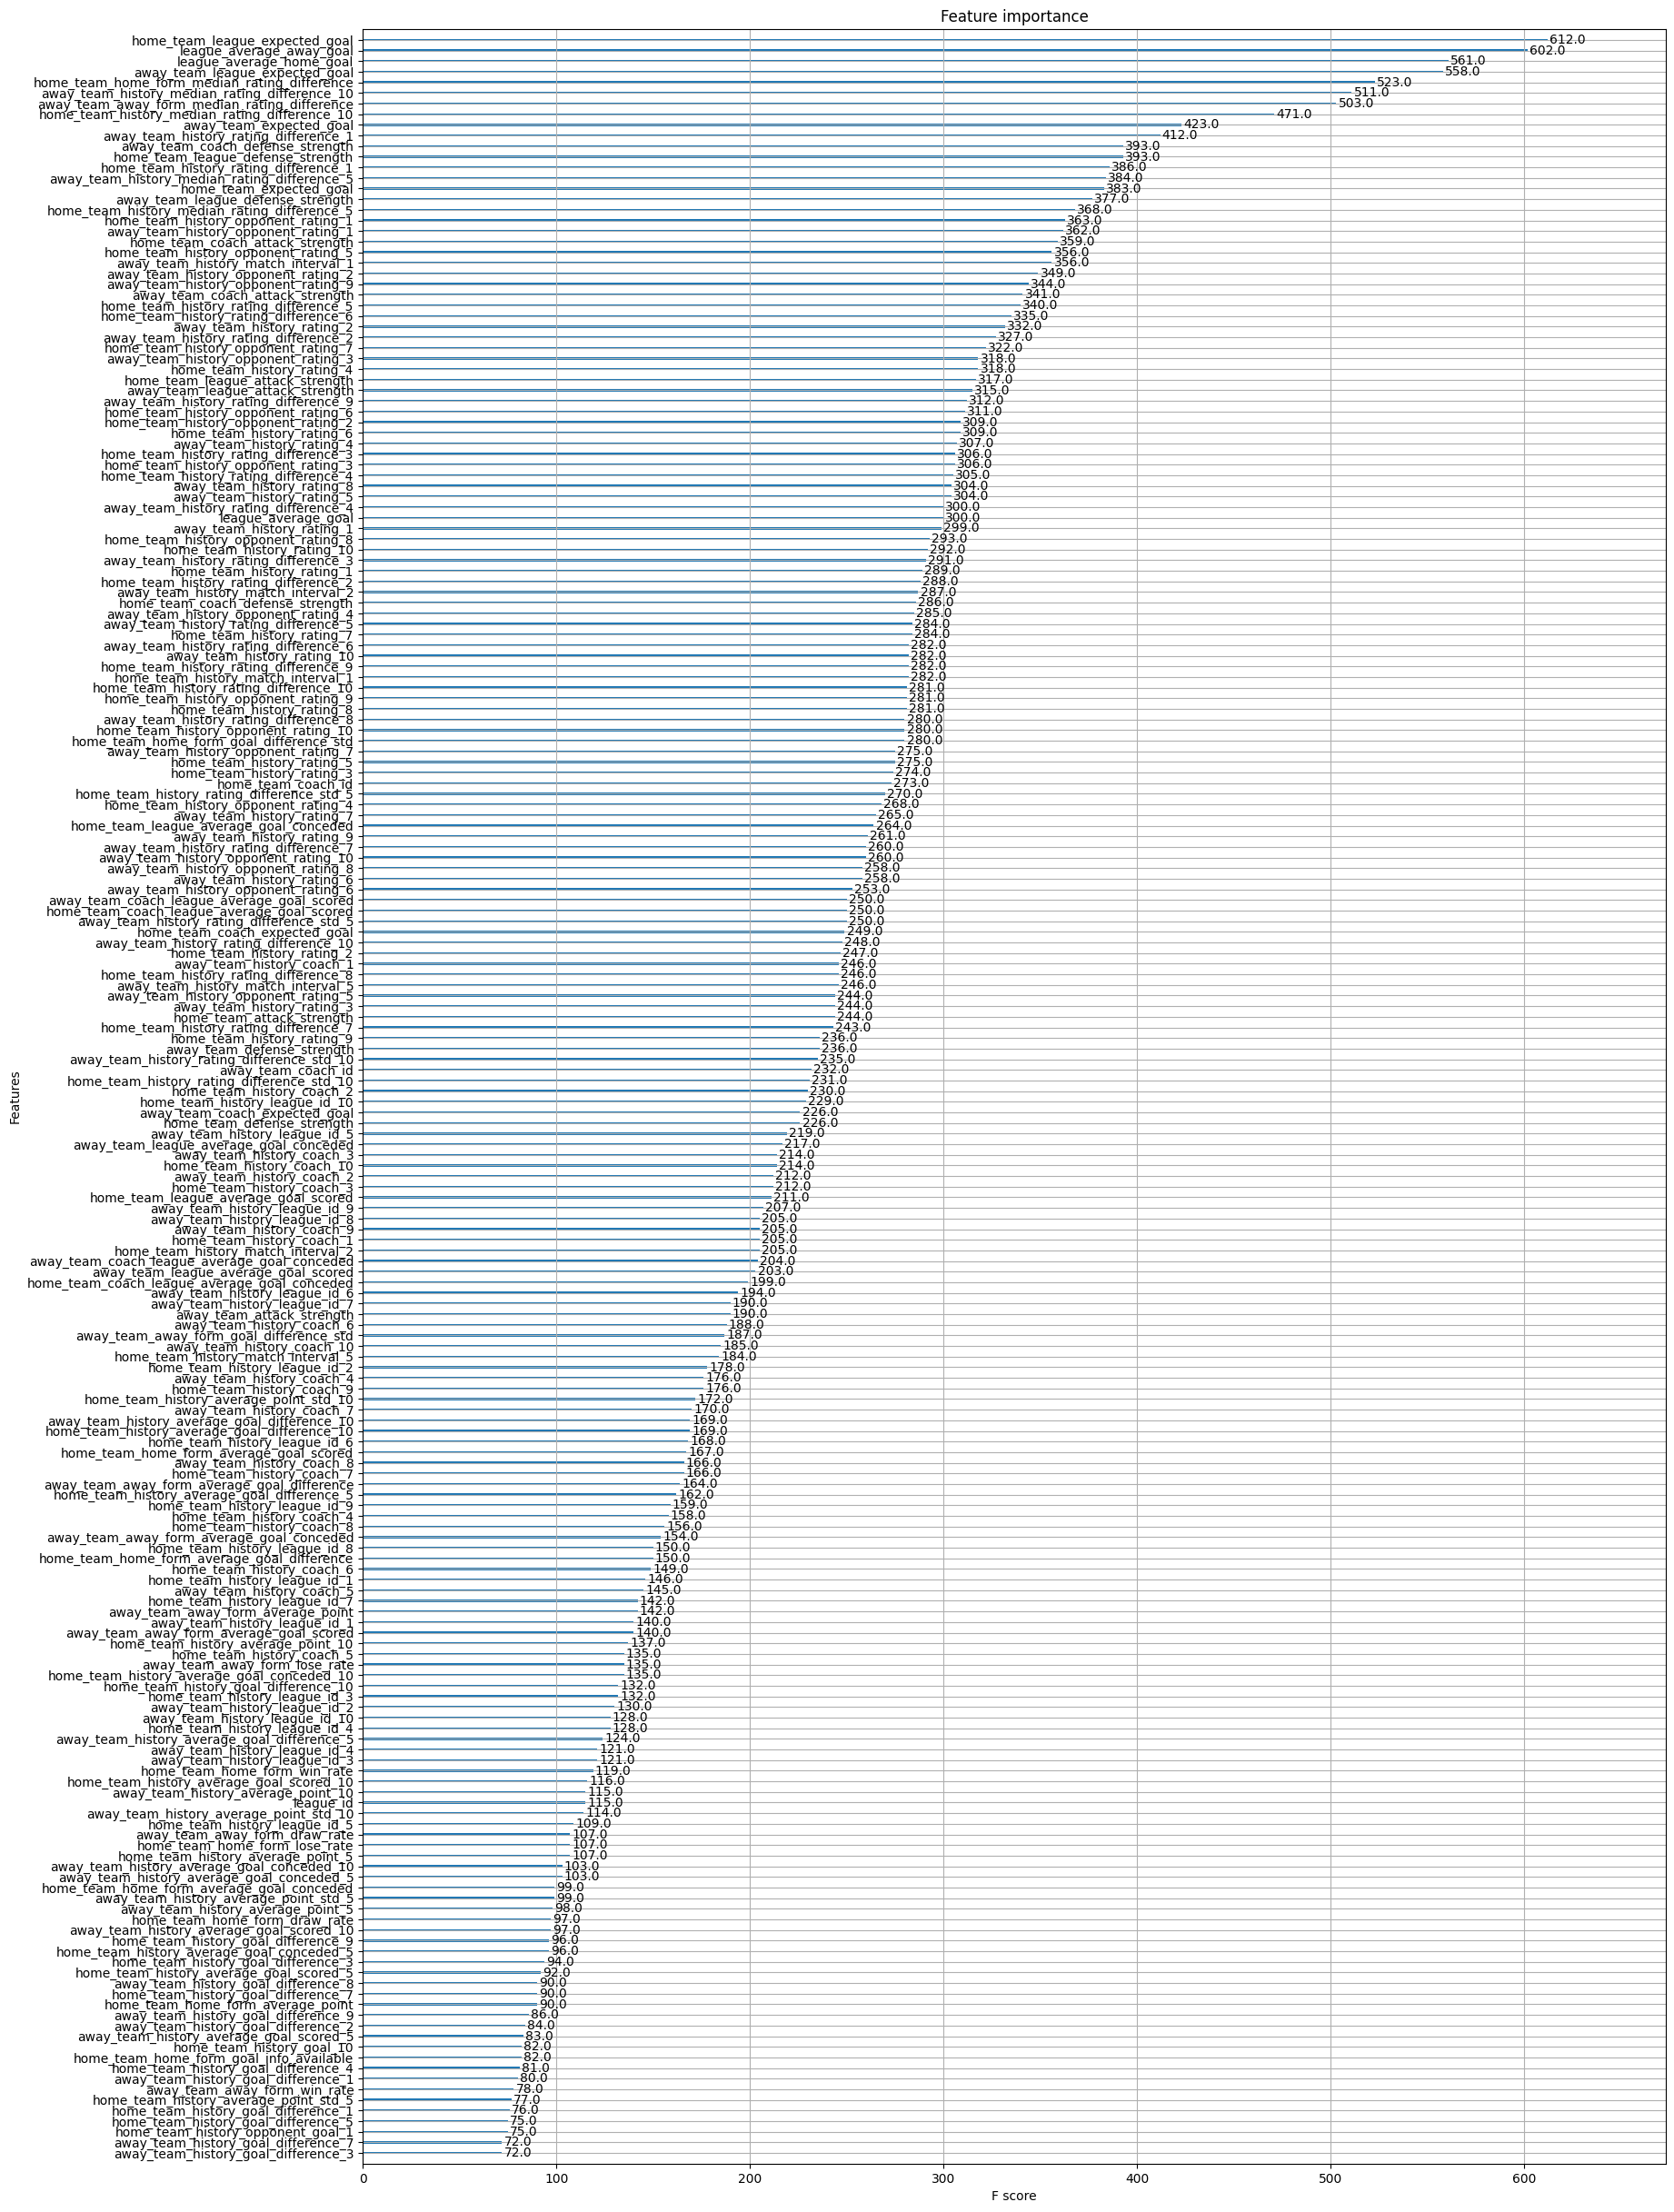

In [28]:
xgb.plot_importance(model, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

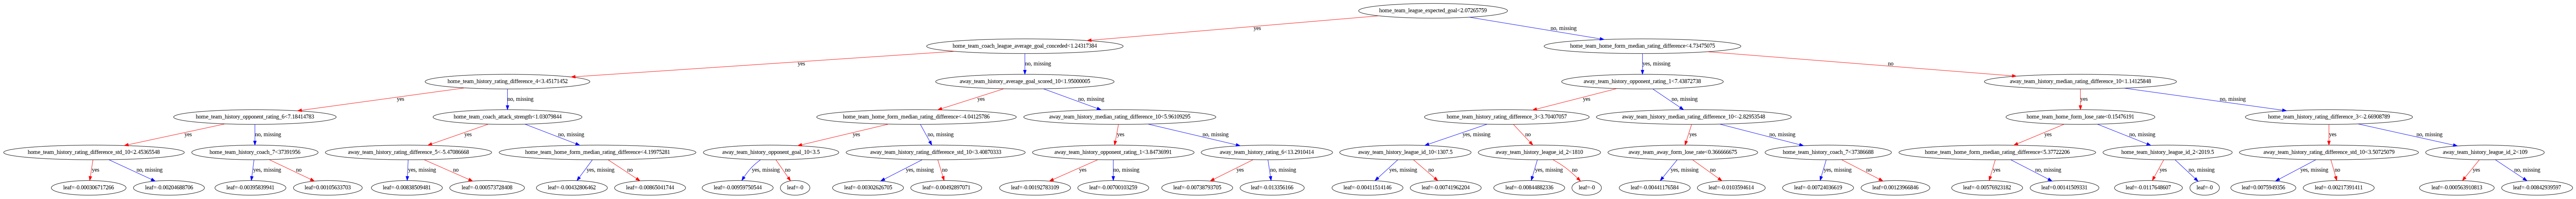

In [29]:
xgb.plot_tree(model, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [30]:
model.best_iteration

542

In [31]:
model.best_score

1.005260989411776

In [41]:
X_test_d = xgb.DMatrix(X_test)
prediction_probs = model.predict(X_test_d, iteration_range=(0, model.best_iteration))

In [46]:
prediction_probs

array([[0.31578365, 0.18808965, 0.49612674],
       [0.2068783 , 0.2902499 , 0.5028718 ],
       [0.29411262, 0.31273362, 0.39315376],
       ...,
       [0.19023672, 0.2638865 , 0.5458768 ],
       [0.3789331 , 0.2888751 , 0.3321918 ],
       [0.3185734 , 0.13116625, 0.55026037]], dtype=float32)

In [44]:
predictions = np.argmax(prediction_probs, axis=1)

In [45]:
predictions

array([2, 2, 2, ..., 2, 0, 2])

In [47]:
y_test

array([0, 2, 2, ..., 1, 2, 0])

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(confusion)

# Generate classification report
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# Calculate macro-averaged F1 score
macro_f1 = f1_score(y_test, predictions, average='macro')
print("Macro F1 Score:", macro_f1)

# Calculate micro-averaged F1 score
micro_f1 = f1_score(y_test, predictions, average='micro')
print("Micro F1 Score:", micro_f1)

# Calculate sample-weighted F1 score
sample_f1 = f1_score(y_test, predictions, average='weighted')
print("Sample-weighted F1 Score:", sample_f1)

Accuracy: 0.5021332852592993
Confusion Matrix:
[[2556  103 2586]
 [1302   98 2790]
 [1398  106 5702]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      5245
           1       0.32      0.02      0.04      4190
           2       0.51      0.79      0.62      7206

    accuracy                           0.50     16641
   macro avg       0.44      0.43      0.38     16641
weighted avg       0.46      0.50      0.43     16641

Macro F1 Score: 0.38470337171485264
Micro F1 Score: 0.5021332852592993
Sample-weighted F1 Score: 0.4344949438504497


In [51]:
label_encoder.classes_

array(['away', 'draw', 'home'], dtype=object)

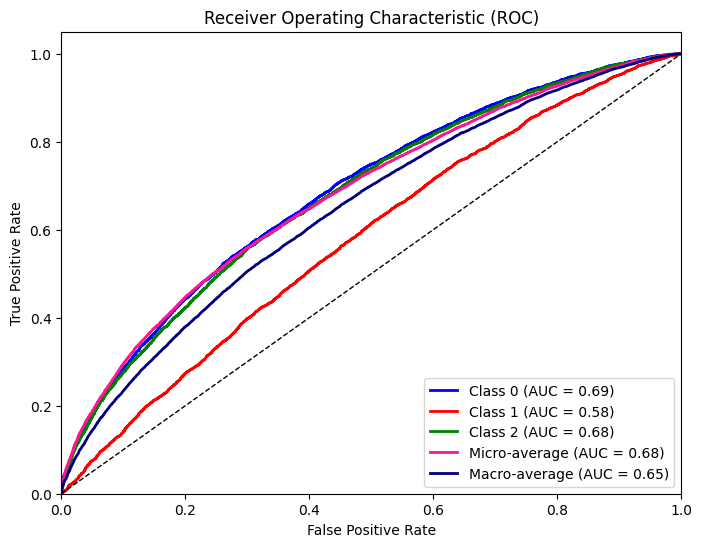

In [59]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], prediction_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), prediction_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', lw=2,
         label='Macro-average (AUC = {0:0.2f})'.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
